<a href="https://colab.research.google.com/github/ziatdinovmax/AISTEM_WORKSHOP_2020/blob/main/Day02/04a_BayesianNN1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bayesian Neural Network for 1D Regression

Author: Maxim Ziatdinov

Email: ziatdinovmax@gmail.com


---
In the Bayesian neural network (BNN), the neural network parameters $W$ (weights and biases) are represented by a prior probability distribution $p(W)$ instead of a single value (point estimate). Performing inference on the BNN calculates the posterior distribution $P(W|D)$ over the network parameters given the observations $D = {(x_1, y_1), . . .(x_N , y_N )}$. The major advantages of BNN over a standard neural network are that it allows modeling uncertainty of the training procedure and that it has a built-in weights regularization, that can be controlled by choosing different priors over the weights, preventing overfitting.

<img src="https://drive.google.com/uc?export=view&id=18jDerymT6GFSRgwSImI7KkLFM0I4RSF6" width=800 px><br><br>


The learning of BNN parameters is done using an iterative version of No-U-Turn sampler (NUTS) for Markov chain Monte Carlo (MCMC) inference as implemented in JAX-based NumPyro probabilistic programming library. The BNN prediction is made via the posterior predictive distribution, $p(y|x,D)=p(y|x,W)p(W|D)dW$, and have the dimension of (*MCMC samples*, *number of test points*), which can be interpreted as predictions from a (weighted) ensemble of classical neural networks, each with its own point estimates of weights and biases. For the visualization of the BNN predictions and the estimated uncertainty in the predictions, we calculate the mean and the variance (spread of distribution) values along the ‘samples’ axis, respectively.


---





Install NumPyro, which is a probabilistic programming library powered by JAX for autograd and JIT compilation to GPU/TPU/CPU.

In [ ]:
!pip install numpyro

Imports:

In [ ]:
# "old" numpy
import numpy as onp
# jax
import jax
import jax.numpy as np
from jax import vmap
import jax.random as random
# numpyro
import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
# plotting
import matplotlib.pyplot as plt

numpyro.set_platform('cpu')

Generate regression set:

In [ ]:
X = np.arange(-10, 10, .1)[:, np.newaxis]
y = np.sin(X) * onp.exp(.2*X) + .3*random.normal(random.PRNGKey(42), shape=X.shape)

Plot generated set:

Text(0, 0.5, 'y')

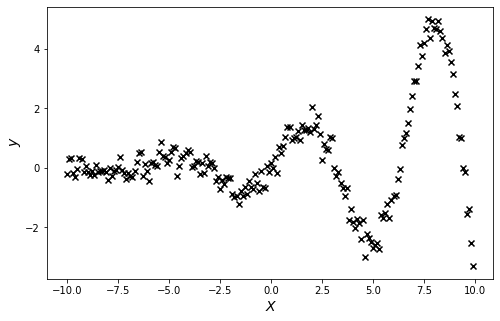

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.scatter(X, y, marker='x', c='k')
ax.set_xlabel('X', fontsize=14, style='italic')
ax.set_ylabel('y', fontsize=14, style='italic')

Define helper finctions for inference of NN weights and prediction on "test" data:

In [ ]:
def run_inference(model, args, rng_key,
                  X, Y, output_dim,
                  print_summary=False):
    """
    Runs the No-U-Turn Sampler (NUTS) for Hamiltonian Monte Carlo
    to infer the weights in bayesian neural network
    """
    kernel = NUTS(model)
    mcmc = MCMC(kernel, 
                args['num_warmup'], 
                args['num_samples'], 
                num_chains=args['num_chains'],
                chain_method='sequential')
    mcmc.run(rng_key, X, Y, args['num_hidden'], output_dim)
    if print_summary:
        mcmc.print_summary() 
    return mcmc.get_samples()


def predict(model, rng_key, samples,
            X, hidden_dim, output_dim,
            return_y=False):

    model = handlers.substitute(handlers.seed(model, rng_key), samples)
    model_trace = handlers.trace(model).get_trace(X=X, y=None,
                                                  hidden_dim=hidden_dim,
                                                  output_dim=output_dim)
    if return_y:
        return model_trace['y']['value']
    model_trace_ = {}
    for k, val in model_trace.items():
        model_trace_[k] = val['value']
    return model_trace_

Helper functions for building a simple Bayesian neural network:

In [ ]:
def sample_weights(name, in_channels, out_channels):
    """Sampling weights tensor"""
    return numpyro.sample(name=name, fn=dist.Normal(
                loc=np.zeros((in_channels, out_channels)), 
                scale=np.ones((in_channels, out_channels))))
    
def sample_biases(name, channels):
    """Sampling bias vector"""
    return numpyro.sample(name=name, fn=dist.Normal(
                loc=np.zeros((channels)), scale=np.ones((channels))))
    
def bnn_layer(z, in_channels, out_channels, 
              w_name, b_name, nonlinearity=True, bias=True):
    """Creates a single BNN layer with non-linear activation"""
    z = np.matmul(z, sample_weights(w_name, in_channels, out_channels),
                  precision=jax.lax.Precision.HIGH)
    if bias:
        z = z + sample_biases(b_name, out_channels)
    if not nonlinearity:
         return z
    return np.tanh(z)

def model(X, y, hidden_dim, output_dim):
    """
    Bayesian neural network with three layers: 

    Args:
        X: numpy array
            training samples
        y: numpy array
            targets (labels)
        hidden_dim: int
            number of neurons
        output_dim: int
            output dimensions
    """
    # Input dimensions
    input_dim = X.shape[-1]
    # Observation noise
    _obs = numpyro.sample("_obs", dist.Gamma(3., 1.))
    sigma_obs = 1 / np.sqrt(_obs)
    # Neural network
    z1 = bnn_layer(X, input_dim, hidden_dim, 'w1', 'b1', nonlinearity=True)
    z2 = bnn_layer(z1, hidden_dim, hidden_dim, 'w2', 'b2', nonlinearity=True)
    z3 = bnn_layer(z2, hidden_dim, output_dim, 'w3', 'b3', nonlinearity=False)
    # "Observe" data
    numpyro.sample("y", dist.Normal(z3, sigma_obs), obs=y)

Run inference:

In [ ]:
args = {
    "num_chains": 1, # Number of chains for MCMC (runs sequentially)
    "num_hidden": 20, # Number of "neurons" in each layer of BNN
    "num_samples": 200, # Number of MCMC samples
    "num_warmup": 300 # number of warmup steps
}
# Infer model parameters
out_d = y.shape[-1]
rng_key, rng_key_predict = random.split(random.PRNGKey(0))
samples = run_inference(model, args, rng_key, X, y, out_d)

sample: 100%|██████████| 500/500 [00:44<00:00, 11.24it/s, 1023 steps of size 1.58e-03. acc. prob=0.90]


Use the learned weights to make a prediction on "test data":

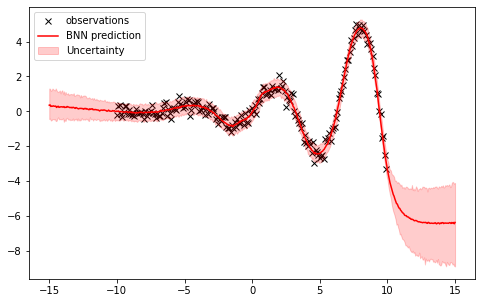

In [ ]:
X_test = np.linspace(-15, 15, 500)[:, np.newaxis]

# get predictions
predict_fn = vmap(
    lambda samples, rng_key: predict(
        model, rng_key, samples, X_test, 
        args['num_hidden'], out_d)
)
predictions_dict = predict_fn(
    samples, random.split(
        rng_key_predict, args['num_samples'] * args['num_chains'])
)
predictions = predictions_dict['y']
PI = np.percentile(predictions, q=(5.5, 94.5), axis=0)

# plot results
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(X[:, 0], y[:, 0], 'x', c='k', label='observations', zorder=0)
ax.plot(X_test[:, 0], np.mean(predictions[..., 0], axis=0),
            c='red', label='BNN prediction', zorder=1)
ax.fill_between(X_test[:, 0], PI[0][:,0], PI[1][:,0],
                color="red", alpha=0.2, label="Uncertainty")
ax.legend()